In [1]:
from pyface.qt import QtGui, QtCore
%matplotlib notebook


# Compute LCMV inverse solution on evoked data in volume source space


Compute LCMV inverse solution on an auditory evoked dataset in a volume source
space. It stores the solution in a nifti file for visualisation e.g. with
Freeview.




In [2]:
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.beamformer import lcmv

from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

print(__doc__)

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_raw-eve.fif'
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-vol-7-fwd.fif'

Automatically created module for IPython interactive environment


Get epochs



The proj parameter has been dprecated and will be removed in 0.14. Use raw.apply_proj() instead.
Opening raw data file /home/phil/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
1 projection items deactivated
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<ipython-input-3-97be5639d0fb>:4: DeprecationWarning: The proj parameter has been dprecated and will be removed in 0.14. Use raw.apply_proj() instead.
  raw = mne.io.read_raw_fif(raw_fname, preload=True, proj=True)
<ipython-input-3-97be5639d0fb>:4: DeprecationWarning: add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
  raw = mne.io.read_raw_fif(raw_fname, preload=True, proj=True)


Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...
72 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 72 events and 421 original time points ...
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    R

<IPython.core.display.Javascript object>


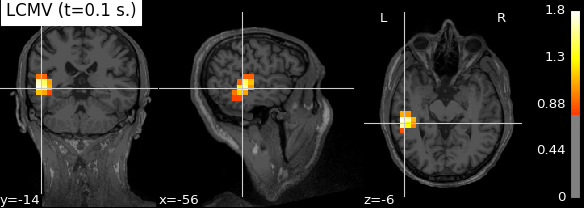

<IPython.core.display.Javascript object>


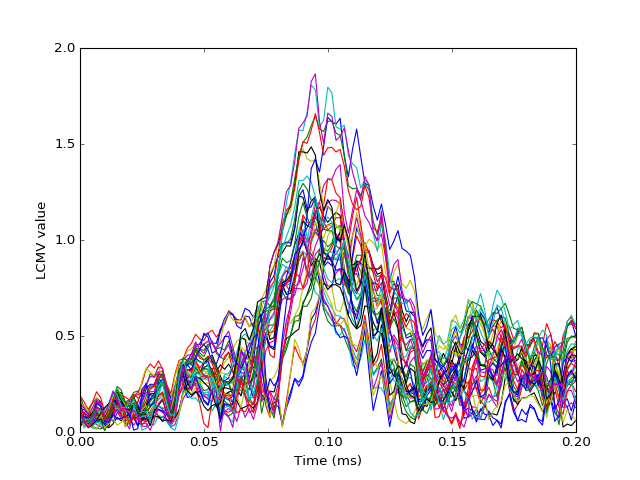

In [3]:
event_id, tmin, tmax = 1, -0.2, 0.5

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname, preload=True, proj=True)
raw.info['bads'] = ['MEG 2443', 'EEG 053']  # 2 bads channels
events = mne.read_events(event_fname)

# Set up pick list: EEG + MEG - bad channels (modify to your needs)
left_temporal_channels = mne.read_selection('Left-temporal')
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, eog=True,
                       exclude='bads', selection=left_temporal_channels)

# Pick the channels of interest
raw.pick_channels([raw.ch_names[pick] for pick in picks])
# Re-normalize our empty-room projectors, so they are fine after subselection
raw.info.normalize_proj()

# Read epochs
proj = False  # already applied
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    baseline=(None, 0), preload=True, proj=proj,
                    reject=dict(grad=4000e-13, mag=4e-12, eog=150e-6))
evoked = epochs.average()

forward = mne.read_forward_solution(fname_fwd)

# Read regularized noise covariance and compute regularized data covariance
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method='shrunk')
data_cov = mne.compute_covariance(epochs, tmin=0.04, tmax=0.15,
                                  method='shrunk')

# Run free orientation (vector) beamformer. Source orientation can be
# restricted by setting pick_ori to 'max-power' (or 'normal' but only when
# using a surface-based source space)
stc = lcmv(evoked, forward, noise_cov, data_cov, reg=0.01, pick_ori=None)

# Save result in stc files
stc.save('lcmv-vol')

stc.crop(0.0, 0.2)

# Save result in a 4D nifti file
img = mne.save_stc_as_volume('lcmv_inverse.nii.gz', stc,
                             forward['src'], mri_resolution=False)

t1_fname = data_path + '/subjects/sample/mri/T1.mgz'

# Plotting with nilearn ######################################################
plot_stat_map(index_img(img, 61), t1_fname, threshold=0.8,
              title='LCMV (t=%.1f s.)' % stc.times[61])

# plot source time courses with the maximum peak amplitudes
plt.figure()
plt.plot(stc.times, stc.data[np.argsort(np.max(stc.data, axis=1))[-40:]].T)
plt.xlabel('Time (ms)')
plt.ylabel('LCMV value')
plt.show()